## Implementação de um Classificador Perceptron

In [2]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
class Perceptron(object):
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                # target - self.predict(xi) -> error
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)

## Testando o classificador Perceptron

In [4]:
X = np.array([[1,1],[2,2],[3,3]])
y = np.array([1,1,-1])

ppn = Perceptron(eta=0.1, n_iter=100)


ppn.fit(X, y)


X_newdata = np.array([[4,4],[2,2],[3,3]])
print("Resultado da Predição",ppn.predict(X_newdata));

Resultado da Predição [-1  1 -1]


## Questao 1 - Implemente uma função para calcular a acurácia do modelo

In [5]:
def accuracy(y_pred, y_true):
    total = len(y_pred)
    matches = np.sum(y_pred == y_true)
    
    return matches / total

A função para calcular a acurácia é bem simples. Passamos como parâmetro a classe target y predita e a classe target real. A acurácia é calculada então como uma proporção entre o total de valores preditos e o número de predições corretas, isto é, predições que coincidem com o valor real do teste.

## Questao 2 - Implemente um método de validação cruzada para testar 

In [103]:
def train_test_split(train, test):
    features = train[0].columns.tolist()
    target = features.pop()
    print("Train:",train)

    X_train = np.array([tr[features].values[0] for tr in train])
    y_train = np.array([tr[target].values[0] for tr in train])
    X_test = np.array(test[features].values)
    y_test = np.array(test[target].values)
    print("XXXXXXXXXXXXXXX Train:", X_train)

    return (X_train, y_train, X_test, y_test)

def cross_validation(perceptron, dataset, n_folds=10, shuffle=False):
    accs = []

    if shuffle:
        dataset = dataset.reindex(np.random.permutation(dataset.index))

    step =  math.floor(len(dataset) / n_folds)
    folds = []
    i = 0
    for _ in range(n_folds):
        folds.append(dataset[i:i+step])
        i += step

    folds_aux = folds.copy()
    for i, fold in enumerate(folds):
        test = folds_aux.pop(i)
        train = folds_aux

        X_train, y_train, X_test, y_test = train_test_split(train, test)

        perceptron.fit(X_train, y_train)
        y_pred = perceptron.predict(X_test)
        accs.append(accuracy(y_pred, y_test))

        folds_aux.insert(i, fold)

    return np.mean(accs)

def cross_validation_model(perceptron, dataset, n_folds=10, shuffle=False):
    accs = []
    acc = 0

    if shuffle:
        dataset = dataset.reindex(np.random.permutation(dataset.index))

    step =  math.floor(len(dataset) / n_folds)
    folds = []
    i = 0
    while i < len(dataset):
        folds.append(dataset[i:i+step])
        i += step

    folds_aux = folds.copy()
    for i, fold in enumerate(folds):
        test = folds_aux.pop(i)
        train = folds_aux

        X_train, y_train, X_test, y_test = train_test_split(train, test)

        perceptron.fit(X_train, y_train)
        y_pred = perceptron.predict(X_test)
        accs.append(accuracy(y_pred, y_test))

        if accs[-1] >= acc:
            bestX, bestY = X_train, y_train

        acc = accs[-1]

        folds_aux.insert(i, fold)

    return accs, bestX, bestY

Criamos dois tipos de função para validação cruzada, primeiramente temos a função que retorna a média das acurácias. A segunda é um pouco mais robusta. Nela podemos passar como parâmetro um perceptron e além dela retornar um vetor com as acurácias para cada fold, ela também retorna o melhor fold para que possamos implementá-los mais facilmente.

In [60]:
ppn = Perceptron(eta=0.3, n_iter=500)
# target must be the last column
data = {
    'X1': [1, 3, 5, 1, 2, 3, 2, 2],
    'X2': [2, 4, 6, 1, 2, 2, 1, 3],
    'y': [-1, 1, -1, 1, 1, -1, 1, 1]
}
dataset = pd.DataFrame(data)
cross_validation(ppn, dataset, n_folds=8, shuffle=True)

0.5

## Teste o classificador usando um conjunto de dados linearmente separável e outro não linearmente separável
### Sugestão: crie datasets sintéticos com apenas dois atributos para voce poder visualizar a separação das classes

In [126]:
def generate_data(n_samples, linear=False):
    random_x = np.arange(0, 10)
    random_y = [1, -1]

    X, y = [], []
    for _ in range(n_samples):
        X.append([random.choice(random_x), random.choice(random_x)])
        if linear:
            if X[-1][0] >= 5:
                y.append(random_y[1])
            else:
                y.append(random_y[0])
        else:
            y.append(random.choice(random_y))

    return np.array(X), np.array(y)

In [127]:
def plot(X, y):
    reds, blues = [], []
    for x, y in zip(X, y):
        if y == -1:
            reds.append(x)
        else:
            blues.append(x)

    transpose_reds = np.transpose(reds)
    transpose_blues = np.transpose(blues)
    
    plt.scatter(transpose_reds[0], transpose_reds[1], c='red')
    plt.scatter(transpose_blues[0], transpose_blues[1], c='blue')
    plt.show()

In [128]:
def evaluate(size, eta, n_iter, linear, showPlot=True):
    X, y = generate_data(size, linear)
    n = len(X)
    limite = math.floor(0.6 * n)
    X_train, y_train = X[0:limite], y[0:limite]
    X_test, y_test = X[limite:n], y[limite:n]

    p = Perceptron(eta=eta, n_iter=n_iter)
    p.fit(X_train, y_train)
    
    if showPlot:
        plot(X, y)
    
    return accuracy(p.predict(X_test), y_test)

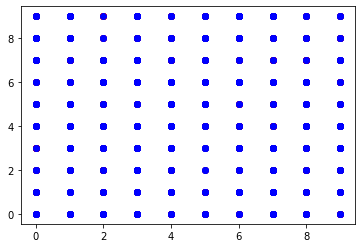

0.485

In [129]:
# Não linear
evaluate(1000, 0.5, 100, False)

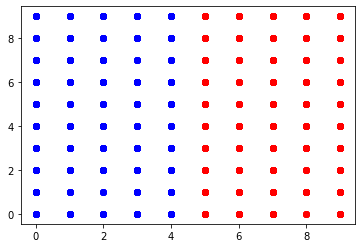

1.0

In [130]:
# Linear
evaluate(1000, 0.5, 100, True)

In [14]:
p = Perceptron(eta=0.5, n_iter=10)
p.fit(Xl, yl)
p.predict([[4, 7]])

array([1])

## Questao 3 - Treine um classificador perceptron para os dados de seu estudo de caso

### Dados:
Primeiramente utilizamos os dados que trabalhamos no estudo de caso anterior. Os dados são registro dos 100 anos das olimpíadas.

In [38]:
df = pd.read_csv('../datasets/athlete_events.csv')
df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


Porém, mesmo que nossa intenção inicial fosse utilizar os mesmos dados, eles não se encaixam muito bem para este tipo classificação. Ainda assim, podemos extrair algum tipo de maneira de classificar, como vamos mostrar mais adiante.
Medalhas, por exemplo, não é algo que seja possível predizer baseado nas features que temos. Claro que o condicionamento físico pode tornar mais provável uma vitória, mas o esporte é algo imprevisível, onde as emoções as vezes fogem da lógica e das probabilidades e geram vitórias e derrotas inesperadas. Sendo assim, procuramos uma melhor maneira de classificar algum tipo de dado no nosso dataset usando o perceptron.

Nossa ideia então foi fazer uma classificação esportiva, isto é, dado algumas features do atleta (Sexo, Altura, Peso e Idade) determinar se ele seria um praticante apto deste esporte específico ou não. Este tipo de análise é uma tentativa de trabalharmos com os dados do último trabalho, que já temos algum conhecimento, e tentar extrair o máximo disto. Para isto, precisamos tratar os dados antes.


Primeiramente vamos remover todos os dados duplicados e NaN nas colunas que são importantes:

In [39]:
_df = df.drop_duplicates(subset='ID', keep="first") #eliminando duplicatas
_df = _df.dropna(axis=0, subset=['Height', 'Weight', 'Age', 'Sex', 'Team']) #eliminando dados NaN

Agora, precisamos remover as colunas com features que não iremos precisar para o modelo:

In [40]:
df_proc = _df.drop(columns=['ID','Name','Year', 'NOC', 'Games', 'Season', 'City', 'Event', 'Medal', 'Team'])
df_proc.head()

,Sex,Age,Height,Weight,Sport
0,M,24.0,180.0,80.0,Basketball
1,M,23.0,170.0,60.0,Judo
4,F,21.0,185.0,82.0,Speed Skating
10,M,31.0,188.0,75.0,Cross Country Skiing
18,M,31.0,183.0,72.0,Cross Country Skiing


Agora, não podemos lidar com strings no modelo, de maneira que os valores têm que ser numéricos. Então vamos trocar a coluna sports pela coluna target. Dado um esporte específico, no nosso caso escolhemos <b>Basquete</b>, a coluna target será preenchida com 1 se aquele atleta pratica o esporte determinado e -1 se ele pratica outro esporte. Em seguida, trocamos o sexo também, se for feminino (F) será representado por 1 e se for masculino (M) será representado com 0. Desta maneira, podemos ter apenas valores númericos nas nossas features e na nossa classe target.

In [41]:
t_sport = 'Basketball'

df_sport = df_proc.copy()
df_sport['Target'] = (df_sport['Sport'] == t_sport).astype(int)
df_sport['Target'] = df_sport['Target'].replace([0],-1)

df_sport['Sex'] = (df_sport['Sex'] == 'F').astype(int)
df_sport = df_sport.drop(columns = ['Sport'])

df_sport.head()

,Sex,Age,Height,Weight,Target
0,0,24.0,180.0,80.0,1
1,0,23.0,170.0,60.0,-1
4,1,21.0,185.0,82.0,-1
10,0,31.0,188.0,75.0,-1
18,0,31.0,183.0,72.0,-1


Acontece que para o perceptron classificar de maneira adequada, os dados devem ser linearmente separáveis. Para termos uma melhor visualização disso, fizemos um gráfico de dispersão com alguma das features (Altura e Peso) do nosso dataset.

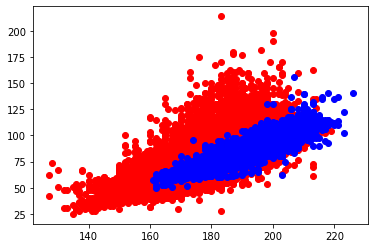

In [53]:
df_target = df_sport.loc[df_sport['Target'] == 1]
df_out_target = df_sport.loc[df_sport['Target'] == -1]

plt.scatter(df_out_target['Height'], df_out_target['Weight'], c='red')
plt.scatter(df_target['Height'], df_target['Weight'], c='blue')

plt.show()

Vemos que os dados vistos no gráfico estão bem sobrepostos e não são facilmente separáveis linearmente. Uma alternativa que pensamos foi no gráfico de dispersão usando três features, assim podemos checar se em três dimensões ele seria separável linearmente (traçando um plano, por exemplo).

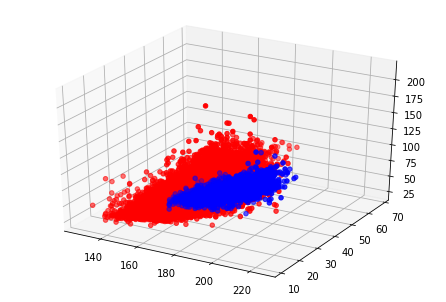

In [51]:
fig = plt.figure()
ax = Axes3D(fig)


df_target = df_sport.loc[df_sport['Target'] == 1]
df_out_target = df_sport.loc[df_sport['Target'] == -1]

ax.scatter(df_target['Height'], df_target['Age'], df_target['Weight'], c='blue')
ax.scatter(df_out_target['Height'],  df_out_target['Age'], df_out_target['Weight'], c='red')

plt.show()

Ainda assim, vemos que os dados estão bem sobrepostos. Porém vamos seguir com as etapas para classificação com o perceptron. Criamos o perceptron, usamos nossa função de validação cruzada para determinar qual a melhor divisão para os dados em teste e treino.

In [106]:
ppc = Perceptron(eta=0.5, n_iter=10)
accs, X_train, y_train = cross_validation_model(ppc, df_sport, n_folds = 10)
accs

Train: [       Sex   Age  Height  Weight  Target
26419    0  25.0   196.0    96.0      -1
26421    1  19.0   193.0    82.0      -1
26422    1  22.0   170.0    57.0      -1
26426    0  26.0   190.0    86.0      -1
26429    0  26.0   184.0    92.0      -1
...    ...   ...     ...     ...     ...
54236    0  31.0   187.0    90.0      -1
54240    0  23.0   188.0    78.0      -1
54244    0  22.0   177.0    80.0      -1
54245    1  20.0   182.0    82.0       1
54246    0  26.0   194.0    97.0      -1

[9908 rows x 5 columns],        Sex   Age  Height  Weight  Target
54248    0  22.0   186.0   100.0      -1
54251    0  23.0   200.0    99.0      -1
54252    0  24.0   184.0    75.0      -1
54253    0  20.0   180.0    90.0      -1
54256    1  21.0   160.0    55.0      -1
...    ...   ...     ...     ...     ...
81942    1  21.0   181.0    73.0      -1
81944    0  27.0   180.0    67.0      -1
81946    0  33.0   175.0    70.0      -1
81947    1  32.0   180.0    81.0      -1
81949    1  30.0   177.

271114    0  30.0   185.0    96.0      -1]
XXXXXXXXXXXXXXX Train: [[  0.  24. 180.  80.]
 [  0.  25. 196.  96.]
 [  1.  23. 161.  58.]
 [  0.  25. 190.  91.]
 [  1.  21. 187.  83.]
 [  1.  22. 172.  70.]
 [  0.  19. 164.  60.]
 [  0.  34. 180.  80.]
 [  1.  20. 162.  62.]
 [  0.  22. 172.  65.]]
Train: [       Sex   Age  Height  Weight  Target
0        0  24.0   180.0    80.0       1
1        0  23.0   170.0    60.0      -1
4        1  21.0   185.0    82.0      -1
10       0  31.0   188.0    75.0      -1
18       0  31.0   183.0    72.0      -1
...    ...   ...     ...     ...     ...
26407    0  22.0   185.0    77.0      -1
26408    0  21.0   182.0    72.0      -1
26415    0  24.0   176.0    75.0      -1
26416    0  25.0   197.0    87.0      -1
26418    0  28.0   187.0    84.0      -1

[9908 rows x 5 columns],        Sex   Age  Height  Weight  Target
26419    0  25.0   196.0    96.0      -1
26421    1  19.0   193.0    82.0      -1
26422    1  22.0   170.0    57.0      -1
26426    0  2

Train: [       Sex   Age  Height  Weight  Target
0        0  24.0   180.0    80.0       1
1        0  23.0   170.0    60.0      -1
4        1  21.0   185.0    82.0      -1
10       0  31.0   188.0    75.0      -1
18       0  31.0   183.0    72.0      -1
...    ...   ...     ...     ...     ...
26407    0  22.0   185.0    77.0      -1
26408    0  21.0   182.0    72.0      -1
26415    0  24.0   176.0    75.0      -1
26416    0  25.0   197.0    87.0      -1
26418    0  28.0   187.0    84.0      -1

[9908 rows x 5 columns],        Sex   Age  Height  Weight  Target
26419    0  25.0   196.0    96.0      -1
26421    1  19.0   193.0    82.0      -1
26422    1  22.0   170.0    57.0      -1
26426    0  26.0   190.0    86.0      -1
26429    0  26.0   184.0    92.0      -1
...    ...   ...     ...     ...     ...
54236    0  31.0   187.0    90.0      -1
54240    0  23.0   188.0    78.0      -1
54244    0  22.0   177.0    80.0      -1
54245    1  20.0   182.0    82.0       1
54246    0  26.0   194.

Train: [       Sex   Age  Height  Weight  Target
0        0  24.0   180.0    80.0       1
1        0  23.0   170.0    60.0      -1
4        1  21.0   185.0    82.0      -1
10       0  31.0   188.0    75.0      -1
18       0  31.0   183.0    72.0      -1
...    ...   ...     ...     ...     ...
26407    0  22.0   185.0    77.0      -1
26408    0  21.0   182.0    72.0      -1
26415    0  24.0   176.0    75.0      -1
26416    0  25.0   197.0    87.0      -1
26418    0  28.0   187.0    84.0      -1

[9908 rows x 5 columns],        Sex   Age  Height  Weight  Target
26419    0  25.0   196.0    96.0      -1
26421    1  19.0   193.0    82.0      -1
26422    1  22.0   170.0    57.0      -1
26426    0  26.0   190.0    86.0      -1
26429    0  26.0   184.0    92.0      -1
...    ...   ...     ...     ...     ...
54236    0  31.0   187.0    90.0      -1
54240    0  23.0   188.0    78.0      -1
54244    0  22.0   177.0    80.0      -1
54245    1  20.0   182.0    82.0       1
54246    0  26.0   194.

[0.9734557932983448,
 0.9716390795316916,
 0.9743641501816713,
 0.9741622930964877,
 0.9738595074687122,
 0.9706297941057731,
 0.9738595074687122,
 0.9727492935002019,
 0.9750706499798143,
 0.9741622930964877,
 0.875]

In [74]:
ppc.fit(X_train, y_train)

In [79]:
len(y_train)

9

A acurácia é bem alta, mas isso é um problema do modelo. Como os dados estão muito sobrepostos o modelo simplesmente prediz o valor que é mais frequente, no caso <b>-1</b>. Isto porque no conjunto inteiro de dados, a maior parte dos dados são de quem não pratica um esporte específico, dentre muitos outros. Sendo assim, ele vai predizer como -1 e acerta uma boa quantidade deles, por isso uma acurácia alta. Mais um motivo para um cientista de dados conhecer e entender cada detalhe sobre o dataset e modelo que está trabalhando e a solução que quer desenvolver.

### Tentativa de análise linear

Como mostrado anteriormente, por mais que a acurácia seja alta, a classificação na verdade não está adequada. Pensamos então em um subset dos nossos dados que fossem linearmente separáveis (ou o mais próximo disso) para que a classificação pudesse ser feita. Ao invés de analisar todos os esportes contra um escolhido, decidimos então tomar apenas dois (Basquete e Ginástica). Assim o classificador decide, baseado nas mesmas features, se é mais provável que aquele atleta seja um atleta de basquete ou de ginástica.

<i> Reiteramos que este tipo de análise é bem limitada e sem grandes aplicações práticas. Ainda assim, insistimos em um tipo de análise que pudesse ser aplicada no nosso dataset.</i>

In [93]:
new_df = _df.copy()
new_df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN
10,6,Per Knut Aaland,M,31.0,188.0,75.0,United States,USA,1992 Winter,1992,Winter,Albertville,Cross Country Skiing,Cross Country Skiing Men's 10 kilometres,NaN
18,7,John Aalberg,M,31.0,183.0,72.0,United States,USA,1992 Winter,1992,Winter,Albertville,Cross Country Skiing,Cross Country Skiing Men's 10 kilometres,NaN


In [99]:
new_df = new_df.loc[new_df['Year'] >= 1900]
new_df_sport =  new_df.loc[(new_df['Sport'] == 'Gymnastics') | (new_df['Sport'] == 'Basketball')]
### acurácia 84% e quase 5K pontos amostrais

new_df_sport.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
41,17,Paavo Johannes Aaltonen,M,28.0,175.0,64.0,Finland,FIN,1948 Summer,1948,Summer,London,Gymnastics,Gymnastics Men's Individual All-Around,Bronze
139,51,Nstor Abad Sanjun,M,23.0,167.0,64.0,Spain,ESP,2016 Summer,2016,Summer,Rio de Janeiro,Gymnastics,Gymnastics Men's Individual All-Around,NaN
167,69,Tamara Abalde Daz,F,19.0,185.0,72.0,Spain,ESP,2008 Summer,2008,Summer,Beijing,Basketball,Basketball Women's Basketball,NaN
264,136,Alessandro Abbio,M,29.0,195.0,85.0,Italy,ITA,2000 Summer,2000,Summer,Sydney,Basketball,Basketball Men's Basketball,NaN


In [107]:
print("Tamanho dos dados filtrados para ambos os esportes: ", len(new_df_sport))
print("Tamanho dos dados filtrados para apenas basquete: ", len(new_df_sport.loc[new_df_sport['Sport'] == 'Basketball']))

Tamanho dos dados filtrados para ambos os esportes:  4793
Tamanho dos dados filtrados para apenas basquete:  2637


Para evitar o mesmo problema que aconteceu anteriormente, checamos o tamanho dos dados completos e o tamanho dos dados da classe desejada. Vemos que a proporção é bem parecida.

In [109]:
t_sport = 'Basketball'
new_df_target = new_df_sport.copy()
new_df_target['Target'] = (new_df_target['Sport'] == t_sport).astype(int)
new_df_target['Target'] = new_df_target['Target'].replace([0],-1)

new_df_target['Sex'] = (new_df_target['Sex'] == 'F').astype(int)
new_df_target = new_df_target.drop(columns=['ID','Name','Year', 'NOC', 'Games', 'Season', 'City', 'Sport','Event', 'Medal', 'Team'])
new_df_target.head()

,Sex,Age,Height,Weight,Target
0,0,24.0,180.0,80.0,1
41,0,28.0,175.0,64.0,-1
139,0,23.0,167.0,64.0,-1
167,1,19.0,185.0,72.0,1
264,0,29.0,195.0,85.0,1


Como no procedimento anterios, adicionamos o Target e trocamos os dados do Sexo para valores numéricos

Agora vamos criar os gráficos de dispersão 2D e 3D dos dados para vermos se eles são linearmente separáveis ou não.

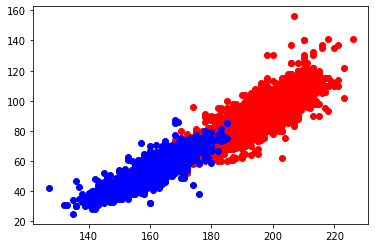

In [112]:
new_df_basket = new_df_target.loc[df_sport['Target'] == 1]
new_df_gym = new_df_target.loc[df_sport['Target'] == -1]

plt.scatter(new_df_basket['Height'], new_df_basket['Weight'], c='red')
plt.scatter(new_df_gym['Height'], new_df_gym['Weight'], c='blue')

plt.show()

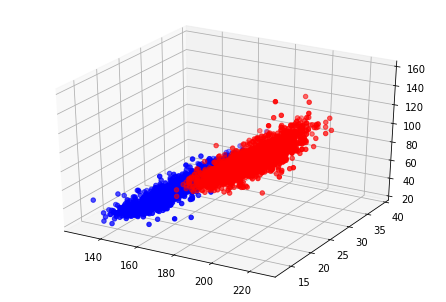

In [114]:
fig = plt.figure()
ax = Axes3D(fig)

new_df_basket = new_df_target.loc[new_df_target['Target'] == 1]
new_df_gym = new_df_target.loc[new_df_target['Target'] == -1]

ax.scatter(new_df_basket['Height'], new_df_basket['Age'], new_df_basket['Weight'],  c='red')
ax.scatter(new_df_gym['Height'], new_df_gym['Age'], new_df_gym['Weight'],  c='blue')

plt.show()

Usando duas features já vemos que ele é bem mais separável do que a outra tentativa. No gráfico 3D também vemos que as classes são mais distinguíveis.

In [225]:
# tam = len(new_df_target)
# limite = math.floor(0.7 * tam)
# Xn_train, yn_train = new_df_target[0:limite].drop(columns = ['Target']), new_df_target[0:limite].drop(columns = ['Sex', 'Age', 'Height', 'Weight'])
# Xn_test, yn_test = new_df_target[limite:tam].drop(columns = ['Target']), new_df_target[limite:tam].drop(columns = ['Sex', 'Age', 'Height', 'Weight'])
ppnc = Perceptron(eta=0.5, n_iter=100)
acc = cross_validation(new_df_target, n_folds=8, shuffle=True)
acc

[0.8697829716193656,
 0.7746243739565943,
 0.7579298831385642,
 0.7512520868113522,
 0.8213689482470785,
 0.7395659432387313,
 0.7813021702838063,
 0.8030050083472454]

In [205]:
ppnc = Perceptron(eta=0.5, n_iter=100)
ppnc.fit(Xn_train.values, yn_train.values)

In [206]:
yn_pred = ppnc.predict(Xn_test.values)
accuracy(yn_pred, np.concatenate(yn_test.values).ravel().tolist())

0.8414464534075105

# Utilizando o perceptron para saber se um paciente tem câncer de mama

## Obtendo o dataset

In [116]:
dataset = pd.read_csv('../datasets/data.csv')
dataset.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Pré-processamento

Recuperar somente as features de interesse. Nesse caso vamos ignorar as colunas 'id', 'unnammed: 32' e 'diagnosis' que será nosso target.

In [117]:
data = dataset[dataset.columns.tolist()[2:len(dataset.columns.tolist())-1]]
data.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Checando se o dataset possui valores nulos

In [118]:
data.isnull().values.any()

False

Montar o nosso vetor de targets. Os valores possíveis de target são B (Benigno) e M (Maligno). Vamos representar M como -1 e B como 1.

In [119]:
target = dataset['diagnosis'].replace(['M', 'B'], [-1, 1])

## Treinamento

Separar o dataset em datasets de treino e de teste para posterior validação.

In [120]:
def split_dataset(dataset, target, shuffle=True):
    n = len(dataset)
    limit = math.floor(0.6 * n)
    
    if shuffle:
        dataset = dataset.reindex(np.random.permutation(dataset.index))
    
    X_train, y_train = dataset[0:limit].values, target[0:limit].values
    X_test, y_test = dataset[limit:n].values, target[limit:n].values
    
    return X_train, y_train, X_test, y_test

In [121]:
X_train, y_train, X_test, y_test = split_dataset(data, target, False)

In [122]:
p = Perceptron(eta=0.1, n_iter=100)
p.fit(X_train, y_train)
y_pred = p.predict(X_test)
acc = accuracy(y_pred, y_test)
print('Acurácia: ', acc)

Acurácia:  0.9254385964912281


## Cross-validation

In [123]:
merged = data.copy()
merged.loc[:, 'diagnosis'] = target
merged.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,-1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,-1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,-1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,-1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,-1


In [124]:
cross_validation(p, merged, shuffle=False)

Train: [     radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
56        19.210         18.57          125.50     1152.0          0.10530   
57        14.710         21.59           95.55      656.9          0.11370   
58        13.050         19.31           82.61      527.2          0.08060   
59         8.618         11.79           54.34      224.5          0.09752   
60        10.170         14.88           64.55      311.9          0.11340   
61         8.598         20.98           54.66      221.8          0.12430   
62        14.250         22.15           96.42      645.7          0.10490   
63         9.173         13.86           59.20      260.9          0.07721   
64        12.680         23.84           82.69      499.0          0.11220   
65        14.780         23.94           97.40      668.3          0.11720   
66         9.465         21.01           60.11      269.4          0.10440   
67        11.310         19.04           71.80      394.

[56 rows x 31 columns]]
XXXXXXXXXXXXXXX Train: [[1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01 2.776e-01 3.001e-01
  1.471e-01 2.419e-01 7.871e-02 1.095e+00 9.053e-01 8.589e+00 1.534e+02
  6.399e-03 4.904e-02 5.373e-02 1.587e-02 3.003e-02 6.193e-03 2.538e+01
  1.733e+01 1.846e+02 2.019e+03 1.622e-01 6.656e-01 7.119e-01 2.654e-01
  4.601e-01 1.189e-01]
 [1.426e+01 1.965e+01 9.783e+01 6.299e+02 7.837e-02 2.233e-01 3.003e-01
  7.798e-02 1.704e-01 7.769e-02 3.628e-01 1.490e+00 3.399e+00 2.925e+01
  5.298e-03 7.446e-02 1.435e-01 2.292e-02 2.566e-02 1.298e-02 1.530e+01
  2.373e+01 1.070e+02 7.090e+02 8.949e-02 4.193e-01 6.783e-01 1.505e-01
  2.398e-01 1.082e-01]
 [1.747e+01 2.468e+01 1.161e+02 9.846e+02 1.049e-01 1.603e-01 2.159e-01
  1.043e-01 1.538e-01 6.365e-02 1.088e+00 1.410e+00 7.337e+00 1.223e+02
  6.174e-03 3.634e-02 4.644e-02 1.569e-02 1.145e-02 5.120e-03 2.314e+01
  3.233e+01 1.553e+02 1.660e+03 1.376e-01 3.830e-01 4.890e-01 1.721e-01
  2.160e-01 9.300e-02]
 [1.327e+01 1.702e+0

XXXXXXXXXXXXXXX Train: [[1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01 2.776e-01 3.001e-01
  1.471e-01 2.419e-01 7.871e-02 1.095e+00 9.053e-01 8.589e+00 1.534e+02
  6.399e-03 4.904e-02 5.373e-02 1.587e-02 3.003e-02 6.193e-03 2.538e+01
  1.733e+01 1.846e+02 2.019e+03 1.622e-01 6.656e-01 7.119e-01 2.654e-01
  4.601e-01 1.189e-01]
 [1.921e+01 1.857e+01 1.255e+02 1.152e+03 1.053e-01 1.267e-01 1.323e-01
  8.994e-02 1.917e-01 5.961e-02 7.275e-01 1.193e+00 4.837e+00 1.025e+02
  6.458e-03 2.306e-02 2.945e-02 1.538e-02 1.852e-02 2.608e-03 2.614e+01
  2.814e+01 1.701e+02 2.145e+03 1.624e-01 3.511e-01 3.879e-01 2.091e-01
  3.537e-01 8.294e-02]
 [1.426e+01 1.965e+01 9.783e+01 6.299e+02 7.837e-02 2.233e-01 3.003e-01
  7.798e-02 1.704e-01 7.769e-02 3.628e-01 1.490e+00 3.399e+00 2.925e+01
  5.298e-03 7.446e-02 1.435e-01 2.292e-02 2.566e-02 1.298e-02 1.530e+01
  2.373e+01 1.070e+02 7.090e+02 8.949e-02 4.193e-01 6.783e-01 1.505e-01
  2.398e-01 1.082e-01]
 [1.327e+01 1.702e+01 8.455e+01 5.464e+02 8.

[56 rows x 31 columns]]
XXXXXXXXXXXXXXX Train: [[1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01 2.776e-01 3.001e-01
  1.471e-01 2.419e-01 7.871e-02 1.095e+00 9.053e-01 8.589e+00 1.534e+02
  6.399e-03 4.904e-02 5.373e-02 1.587e-02 3.003e-02 6.193e-03 2.538e+01
  1.733e+01 1.846e+02 2.019e+03 1.622e-01 6.656e-01 7.119e-01 2.654e-01
  4.601e-01 1.189e-01]
 [1.921e+01 1.857e+01 1.255e+02 1.152e+03 1.053e-01 1.267e-01 1.323e-01
  8.994e-02 1.917e-01 5.961e-02 7.275e-01 1.193e+00 4.837e+00 1.025e+02
  6.458e-03 2.306e-02 2.945e-02 1.538e-02 1.852e-02 2.608e-03 2.614e+01
  2.814e+01 1.701e+02 2.145e+03 1.624e-01 3.511e-01 3.879e-01 2.091e-01
  3.537e-01 8.294e-02]
 [1.426e+01 1.965e+01 9.783e+01 6.299e+02 7.837e-02 2.233e-01 3.003e-01
  7.798e-02 1.704e-01 7.769e-02 3.628e-01 1.490e+00 3.399e+00 2.925e+01
  5.298e-03 7.446e-02 1.435e-01 2.292e-02 2.566e-02 1.298e-02 1.530e+01
  2.373e+01 1.070e+02 7.090e+02 8.949e-02 4.193e-01 6.783e-01 1.505e-01
  2.398e-01 1.082e-01]
 [1.747e+01 2.468e+0

Train: [    radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0        17.990         10.38          122.80     1001.0          0.11840   
1        20.570         17.77          132.90     1326.0          0.08474   
2        19.690         21.25          130.00     1203.0          0.10960   
3        11.420         20.38           77.58      386.1          0.14250   
4        20.290         14.34          135.10     1297.0          0.10030   
5        12.450         15.70           82.57      477.1          0.12780   
6        18.250         19.98          119.60     1040.0          0.09463   
7        13.710         20.83           90.20      577.9          0.11890   
8        13.000         21.82           87.50      519.8          0.12730   
9        12.460         24.04           83.97      475.9          0.11860   
10       16.020         23.24          102.70      797.8          0.08206   
11       15.780         17.89          103.60      781.0          0.

Train: [    radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0        17.990         10.38          122.80     1001.0          0.11840   
1        20.570         17.77          132.90     1326.0          0.08474   
2        19.690         21.25          130.00     1203.0          0.10960   
3        11.420         20.38           77.58      386.1          0.14250   
4        20.290         14.34          135.10     1297.0          0.10030   
5        12.450         15.70           82.57      477.1          0.12780   
6        18.250         19.98          119.60     1040.0          0.09463   
7        13.710         20.83           90.20      577.9          0.11890   
8        13.000         21.82           87.50      519.8          0.12730   
9        12.460         24.04           83.97      475.9          0.11860   
10       16.020         23.24          102.70      797.8          0.08206   
11       15.780         17.89          103.60      781.0          0.

Train: [    radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0        17.990         10.38          122.80     1001.0          0.11840   
1        20.570         17.77          132.90     1326.0          0.08474   
2        19.690         21.25          130.00     1203.0          0.10960   
3        11.420         20.38           77.58      386.1          0.14250   
4        20.290         14.34          135.10     1297.0          0.10030   
5        12.450         15.70           82.57      477.1          0.12780   
6        18.250         19.98          119.60     1040.0          0.09463   
7        13.710         20.83           90.20      577.9          0.11890   
8        13.000         21.82           87.50      519.8          0.12730   
9        12.460         24.04           83.97      475.9          0.11860   
10       16.020         23.24          102.70      797.8          0.08206   
11       15.780         17.89          103.60      781.0          0.

Train: [    radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0        17.990         10.38          122.80     1001.0          0.11840   
1        20.570         17.77          132.90     1326.0          0.08474   
2        19.690         21.25          130.00     1203.0          0.10960   
3        11.420         20.38           77.58      386.1          0.14250   
4        20.290         14.34          135.10     1297.0          0.10030   
5        12.450         15.70           82.57      477.1          0.12780   
6        18.250         19.98          119.60     1040.0          0.09463   
7        13.710         20.83           90.20      577.9          0.11890   
8        13.000         21.82           87.50      519.8          0.12730   
9        12.460         24.04           83.97      475.9          0.11860   
10       16.020         23.24          102.70      797.8          0.08206   
11       15.780         17.89          103.60      781.0          0.

0.8178571428571428

In [125]:
accs

[0.9734557932983448,
 0.9716390795316916,
 0.9743641501816713,
 0.9741622930964877,
 0.9738595074687122,
 0.9706297941057731,
 0.9738595074687122,
 0.9727492935002019,
 0.9750706499798143,
 0.9741622930964877,
 0.875]